In [3]:
import os
import math
import pandas as pd

def calculate_h_index(quotation): #h_ndex
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    h_index = 0
    for i, quotation in enumerate(quotation):
        if quotation >= i + 1:
            h_index = i + 1
        else:
            break

    return h_index

def calculate_i10_index(quotation):  #i10_index
    i10_index = sum(1 for quotation in quotation if quotation >= 10)
    return i10_index

def calculate_g_index(quotation):  #g_index
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    g_index = 0
    quotation_sum=0
    for i, quotation in enumerate(quotation):
        quotation_sum+=quotation
        if quotation_sum >= (i + 1)**2:
            g_index = i + 1

    return g_index

#Object 타입에서 숫자형 체크용
def is_numeric(value):
    try:
        float(value)  # float으로 변환 가능한 경우 숫자
        return True
    except (ValueError, TypeError):
        return False

def recentness(pYears):
    # dt = datetime.datetime.now()#현재날짜
    dt = 2013
    rct = 0
    lct = 0
    if len(pYears) != 0:
        year_avg = sum(pYears) / len(pYears)
        if year_avg >= int(dt)-3: #int(dt.year)-2:
            lct = 1
        else:
            lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)
        # elif int(dt)-15 < year_avg <= int(dt)-3:
        #     lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)

        rct = len(pYears) #연도 개수

    return rct, lct

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [4]:
#authors.all 파일 위치 주소
authors_file_path = r"./gsc_data/authors.all"

try:
    with open(authors_file_path, 'r', encoding='cp1252') as file:
        lines = file.read().splitlines()
        data = [line.split('|') for line in lines]
        columns = ["Valid", "Name", "Affiliation", "Email Domain", "Citation Count", "ID"]
        df_a = pd.DataFrame(data,columns=columns) # authors 의 a
        # df_a = df_a.drop(columns=["C6", "C7"])
        print("변환 완료")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")
except UnicodeDecodeError:
    print("파일을 ANSI(Windows-1252) 인코딩으로 열 수 없습니다.")
    
df_a_copy = df_a.copy()  # df_a의 복사본 생성

for index, row in df_a_copy.iterrows():
    if pd.isna(row[5]):  
        if pd.isna(row[4]):
            if pd.isna(row[3]):  # 1의 경우
                row[5] = row[2] 
            else:  # 2,3,4 의 경우
                row[5] = row[3]
                if is_numeric(row[2]): # 4의 경우
                    row[4] = row[2]
                    row[2] = None
                    row[3] = None
                elif '.' in str(row[2]):  # 3의 경우
                    row[3] = row[2]
                    row[2] = None
                    row[4] = None
                else: # 2의 경우
                    row[3] = None
        else:  # 5,6,7 의 경우
            row[5] = row[4] 
            if is_numeric(row[3]): # 6,7 의 경우
                row[4] = row[3]
                if '.' in str(row[2]): # 7 의 경우
                    row[3] = row[2]
                    row[2] = None
                else: # 6의 경우
                    
                    row[3] = None
            else: #5의 경우
                row[4] = None

변환 완료


In [5]:
#gsc_data\DATA 폴더 경로
folder_path = r"./gsc_data/DATA/"

max_scoquality = 4163.932305363874
max_rct = 6047
max_rct1 = []
max_scoquality1 = []
max_lct = []

years_dict = {}

# df_a_copy의 각 행에서 1번 열의 값을 추출
for index, row in df_a_copy.iterrows():
    name = row[5]  # 1번 열의 값
    
    # 파일 경로 생성
    file_path = os.path.join(folder_path, name + "_.dat")
    
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            # 파일의 각 줄을 읽어 리스트로 저장
            lines = file.readlines()

        # 각 줄을 나누어서 리스트로 저장
        line_lists = [line.strip().split('|') for line in lines]
        
        #빈 리스트 생성
        citations = [] #인용수
        years = [] #연도
        scoquality = 0 #품질
        for line_list in line_lists:
            if len(line_list) > 0:
                if int(line_list[1]) >= 2008:
                    citations.append(int(line_list[0]))
                    years.append(int(line_list[1]))
                    if line_list[1] in years_dict:
                        years_dict[line_list[1]] += 1
                    else:
                        years_dict[line_list[1]] = 1
                    scoquality += math.log(int(line_list[0])*math.exp((int(line_list[1])-2013)/10)+1)

        sum_citations = sum(citations)
        
        # print(name, years)
        max_scoquality1.append(scoquality)
        rct, lct = recentness(years)
        max_lct.append(lct)
        max_rct1.append(rct)
        norm_scoquality = scoquality/max_scoquality
        # norm_recentness = rct/max_rct*0.66*lct
        norm_recentness = ((rct/max_rct)+lct)*0.5
        score = (norm_scoquality*60 + norm_recentness*40)
        # print(rct, scoquality, scoquality/max_scoquality, rct/max_rct, lct, norm_recentness, score)
        #각 index 계산 후 df_a_copy에 새로운 열로 추가
        df_a_copy.at[index,"sum_citation"] = sum_citations
        df_a_copy.at[index,"Paper Count"] = len(citations)
        df_a_copy.at[index,"h-index"] = calculate_h_index(citations)
        df_a_copy.at[index,"i10-index"] = calculate_i10_index(citations)
        df_a_copy.at[index,"g-index"] = calculate_g_index(citations)
        df_a_copy.at[index,"scoquality"] = norm_scoquality
        df_a_copy.at[index,"recentness"] = norm_recentness
        df_a_copy.at[index,"score"] = score
    
    else:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        
df_a_copy['ID'] = 'id_' + df_a_copy['ID']

# print(max_scoquality1)
print(max(max_scoquality1))
print(max(max_rct1))
print(max(max_lct))

# print(df_a_copy)
df_a_copy.head(20)
df_a_copy.to_csv('output.csv', index=False)
df_a_copy.to_csv('output_index.csv', index=True)

4163.932305363874
6047
1
0.00585784603797938
0.5013229700678022


In [135]:
years_dict

{'2008': 344230,
 '2009': 373357,
 '2010': 406790,
 '2011': 446358,
 '2012': 184893,
 '2013': 231,
 '2019': 3,
 '2016': 2,
 '2020': 17,
 '2015': 19,
 '2017': 1,
 '2014': 1,
 '2018': 0}

In [106]:
import csv
import pandas as pd

# CSV 파일 경로
raw_data = 'output.csv'
df = pd.read_csv(raw_data)

#지수별로 내림차순 정렬
H_sorted=df.sort_values(by='h-index', ascending=False)
I10_sorted=df.sort_values(by='i10-index', ascending=False)
G_sorted=df.sort_values(by='g-index', ascending=False)
Citation_sorted=df.sort_values(by='Citation Count', ascending=False)
PaperC_sorted=df.sort_values(by='Paper Count', ascending=False)
scoquality_sorted=df.sort_values(by='scoquality', ascending=False)
recentness_sorted=df.sort_values(by='recentness', ascending=False)
score_sorted=df.sort_values(by='score', ascending=False)

#필요없는 컬럼 삭제
H_sorted=H_sorted.reset_index(drop=True, inplace=False)
I10_sorted=I10_sorted.reset_index(drop=True, inplace=False)
G_sorted=G_sorted.reset_index(drop=True, inplace=False)
Citation_sorted=Citation_sorted.reset_index(drop=True, inplace=False)
PaperC_sorted=PaperC_sorted.reset_index(drop=True, inplace=False)
scoquality_sorted=scoquality_sorted.reset_index(drop=True, inplace=False)
recentness_sorted=recentness_sorted.reset_index(drop=True, inplace=False)
score_sorted=score_sorted.reset_index(drop=True, inplace=False)

#지수 순위 입력
# num=int(input("숫자 입력 : "))
num=100

#해당 순위이내의 결과만 남김
H_sorted = H_sorted.head(num)
I10_sorted = I10_sorted.head(num)
G_sorted = G_sorted.head(num)
score_sorted = score_sorted.head(num)

Citation_sorted = Citation_sorted.head(num)
PaperC_sorted = PaperC_sorted.head(num)
scoquality_sorted = scoquality_sorted.head(num)
recentness_sorted = recentness_sorted.head(num)

score_sorted.drop(columns=['Valid', 'Affiliation', 'h-index', 'i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness'], axis=1, inplace=True)
H_sorted.drop(columns=['Valid', 'Affiliation', 'i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
I10_sorted.drop(columns=['Valid','Affiliation', 'h-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
G_sorted.drop(columns=['Valid','Affiliation', 'i10-index', 'h-index', 'Citation Count','Email Domain',  'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)

score_sorted.columns=['name', 'ID', 'score']
H_sorted.columns=['name','ID','h_score']
I10_sorted.columns=['name','ID','i10_score']
G_sorted.columns=['name','ID','g_score']

score_sorted['rank'] = score_sorted['score'].rank(method='min', ascending=False).astype(int)
H_sorted['rank'] = H_sorted['h_score'].rank(method='min', ascending=False).astype(int)
I10_sorted['rank'] = I10_sorted['i10_score'].rank(method='min', ascending=False).astype(int)
G_sorted['rank'] = G_sorted['g_score'].rank(method='min', ascending=False).astype(int)

H_sorted.to_csv('H_sorted.csv')
I10_sorted.to_csv('I10_sorted.csv')
G_sorted.to_csv('G_sorted.csv')
Citation_sorted.to_csv('Citation_sorted.csv')
PaperC_sorted.to_csv('PaperC_sorted.csv')
scoquality_sorted.to_csv('scoquality_sorted.csv')
recentness_sorted.to_csv('recentness_sorted.csv')
score_sorted.to_csv('score_sorted.csv')

H_name = set(H_sorted['ID'][0:num])
I10_name = set(I10_sorted['ID'][0:num])
G_name = set(G_sorted['ID'][0:num])
S_name = set(score_sorted['ID'][0:num])

common_names = H_name.intersection(I10_name, G_name, S_name)

df1_common = H_sorted[H_sorted['ID'].isin(common_names)]
df2_common = I10_sorted[I10_sorted['ID'].isin(common_names)]
df3_common = G_sorted[G_sorted['ID'].isin(common_names)]
# df4_common = score_sorted[score_sorted['ID'].isin(common_names)]

df_common = pd.merge(df1_common, df2_common, on='ID')
df_common = pd.merge(df_common, df3_common, on='ID')
# df_common = pd.merge(df_common, df4_common, on='ID')


print(S_name)
print(len(H_name), len(I10_name), len(G_name), len(S_name))

anser1  = set(df_common['ID'])

common_names1 = H_name.intersection(anser1)
common_names2 = I10_name.intersection(anser1)
common_names3 = G_name.intersection(anser1)
common_names4 = S_name.intersection(anser1)

print(common_names)
print(len(common_names))
print(common_names1)
print(len(common_names1))
print(common_names2)
print(len(common_names2))
print(common_names3)
print(len(common_names3))
print(common_names4)
print(len(common_names4))

{'id_3kI52KAAAAAJ', 'id_775UehEAAAAJ', 'id_uD-FbvIAAAAJ', 'id_dc5FSKcAAAAJ', 'id_L8XYpAwAAAAJ', 'id_KR7K-XEAAAAJ', 'id_b5tAkfwAAAAJ', 'id_0tEMY3kAAAAJ', 'id_ZHEVF3oAAAAJ', 'id_zBz9dP8AAAAJ', 'id_jN57uy4AAAAJ', 'id_4MRp5MAAAAAJ', 'id_AhUfKjkAAAAJ', 'id_aBdQ4qcAAAAJ', 'id_5q27PVUAAAAJ', 'id_hAOwUSEAAAAJ', 'id_LA_uaB8AAAAJ', 'id_lPEYqq0AAAAJ', 'id_9E5i-fUAAAAJ', 'id_XSGHN8IAAAAJ', 'id_g3lthZYAAAAJ', 'id_Hl5HymUAAAAJ', 'id_AusHCVIAAAAJ', 'id_KZk2nYcAAAAJ', 'id_OLG9E-sAAAAJ', 'id_GY5PGRkAAAAJ', 'id_dvTrT2wAAAAJ', 'id_OH5OPd4AAAAJ', 'id_ANUnBIgAAAAJ', 'id_nhL9PHwAAAAJ', 'id_7AgGeAgAAAAJ', 'id__plRpWEAAAAJ', 'id_kkJMCHEAAAAJ', 'id_-NCwYSUAAAAJ', 'id_fDd9M9AAAAAJ', 'id_anDLFa0AAAAJ', 'id_9gpR5y0AAAAJ', 'id_zjG_ufEAAAAJ', 'id_vQ0c5jEAAAAJ', 'id_-qcSoakAAAAJ', 'id_OG0JzcUAAAAJ', 'id_BVke6rMAAAAJ', 'id_i4FbIEcAAAAJ', 'id_KgjF-HgAAAAJ', 'id__yF5knkAAAAJ', 'id_B-v3OxoAAAAJ', 'id_KFn1SBoAAAAJ', 'id_Il6ArO0AAAAJ', 'id_m9vjm0wAAAAJ', 'id_QoT07LsAAAAJ', 'id_joXwsPIAAAAJ', 'id_iJW63VIAAAAJ', 'id_bpSFN5Q

In [9]:
all_ranks = pd.concat([H_sorted, I10_sorted, G_sorted])

# 이름을 기준으로 등수 합계 계산
rank_sum = all_ranks.groupby('ID').sum().reset_index()

# 결과 출력
print(rank_sum)

                 ID  h_score  rank  i10_score  g_score
0   id_-zgxVEUAAAAJ      0.0    25      457.0      0.0
1   id_0A_lO2UAAAAJ    125.0    32      662.0    302.0
2   id_0DEykT4AAAAJ    106.0    33     1253.0      0.0
3   id_1fatN9EAAAAJ    123.0    55      729.0    250.0
4   id_1sSj1fYAAAAJ    105.0    77        0.0    229.0
5   id_2Dd5uoIAAAAJ     97.0    49        0.0      0.0
6   id_3PCz1j0AAAAJ      0.0    44      400.0      0.0
7   id_3d_DFCYAAAAJ    110.0    23        0.0      0.0
8   id_4R7_wW8AAAAJ     98.0    87        0.0    232.0
9   id_5q4fhUoAAAAJ      0.0     6        0.0    335.0
10  id_7EelTwgAAAAJ    115.0    31        0.0    284.0
11  id_7Q6OSvsAAAAJ      0.0    17      521.0      0.0
12  id_7y4VxjsAAAAJ      0.0    47      395.0      0.0
13  id_9d7rMrkAAAAJ    139.0    42      435.0    421.0
14  id_9gpR5y0AAAAJ    102.0    37     1426.0      0.0
15  id_A9e6sPYAAAAJ      0.0    49      389.0      0.0
16  id_AKqYlxMAAAAJ    163.0    34      441.0    524.0
17  id_Ahg

In [ ]:
# for index, row in rank_sum.iterrows():
#     if row['h_score']==0:
#         rank_sum.loc[index, 'rank'] += 0
#     if row['i10_score']==0:
#         rank_sum.loc[index, 'rank'] += 0
#     if row['g_score']==0:
#         rank_sum.loc[index, 'rank'] += 0


rank_sum = rank_sum.sort_values(by='rank', ascending=True)
rank_sum=rank_sum.reset_index(drop=True, inplace=False)

print(rank_sum)

In [33]:
rank_sum50=rank_sum[0:100]

print(rank_sum50)

                 ID                                               name  h_score  rank  i10_score  g_score
0   id_M5_mEHQAAAAJ  Graham Colditz, MD, DrPHGraham Colditz, MD, Dr...    213.0    12      825.0    366.0
1   id_d_lp40IAAAAJ      Pierre BourdieuPierre BourdieuPierre Bourdieu    180.0    18      583.0    501.0
2   id_E2-uIQYAAAAJ                     Eric TopolEric TopolEric Topol    159.0    25      894.0    274.0
3   id_0A_lO2UAAAAJ      Jacques DerridaJacques DerridaJacques Derrida    125.0    32      662.0    302.0
4   id_I6dIhHQAAAAJ                        Karl MarxKarl MarxKarl Marx    125.0    33      621.0    307.0
5   id_AKqYlxMAAAAJ      Michel FoucaultMichel FoucaultMichel Foucault    163.0    34      441.0    524.0
6   id_F4P3ghEAAAAJ            Eugene KooninEugene KooninEugene Koonin    144.0    37      536.0    272.0
7   id_9d7rMrkAAAAJ            Herbert SimonHerbert SimonHerbert Simon    139.0    42      435.0    421.0
8   id_OU05Q_MAAAAJ            Guido KroemerGu

In [29]:
#몇등까지 보실래요
rank=14 #사용자가 수정

score_list=score_sorted['ID'].values
# score_list=H_sorted['ID'].values
# score_list=g_sorted['ID'].values
# score_list=I10_sorted['ID'].values

answer_list=df_common['ID'].values

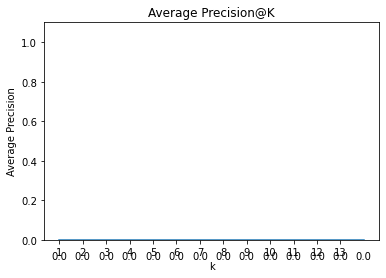

In [30]:
#Average precision@K
#k=rank 추천받을 사람 수
#rel=3개 지수가 만든 저자 목록에 전문가지수가 만든 저자가 포함 되어있다면 1, 아니라면 0
#m+사용자가 추천받은 것들 중 만족한 개수
import matplotlib.pyplot as plt

rel_list=score_list
rel_list = [1 if item in answer_list else 0 for item in score_list]
precision_list=[]
cnt_1=0
for k in range(rank):
    if rel_list[k]==1:
        cnt_1+=1

    precision_k=round(cnt_1/(k+1), 3)
    precision_list.append(precision_k)

k_list = list(range(1, rank + 1))

# 선 그래프 그리기
plt.plot(k_list, precision_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], precision_list[i] - 0.1, str(precision_list[i]), ha='center')

plt.xticks(range(1, 14))

# 그래프 제목 설정
plt.title("Average Precision@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("Average Precision")

# 그래프 보여주기
plt.show()


[14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[14, 27.0, 34.57115704285749, 40.07115704285749, 44.377922623591424, 47.8595978887023, 50.70925538556647, 53.04258871889981, 54.93537797961418, 56.44052795793409, 56.44052795793409, 56.44052795793409, 56.98100426678872, 57.243653801825914]
[14, 27.0, 34.57115704285749, 40.07115704285749, 44.377922623591424, 47.8595978887023, 50.70925538556647, 53.04258871889981, 54.93537797961418, 56.44052795793409, 57.59678726320564, 58.43361610015903, 58.974092409013664, 59.236741944050856]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.966, 0.966, 0.966]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.966, 0.966, 0.966]


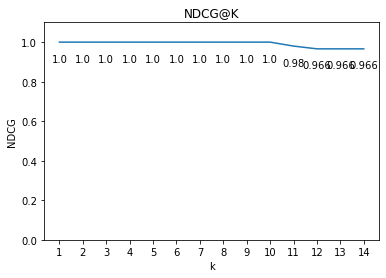

In [28]:
#NDCG@K
#NDCG=DCG/IDCG
import math

i=rank
rel_rank_list=[]
for item in score_list:
    if item in answer_list:
        rel_rank_list.append(i)  # 순위 추가
    else:
        rel_rank_list.append(0)  # 해당 항목이 answer_list에 없으면 0 추가
    i -= 1

print(rel_rank_list)

i=0
ideal_rel_rank_list = [i+1 for i in range(rank)]
ideal_rel_rank_list=ideal_rel_rank_list[::-1]
print(ideal_rel_rank_list)

DCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        DCG_list[k] = (rel_rank_list[k]/math.log2(k+1)) + DCG_list[k-1]
    else:
        DCG_list[k] = rel_rank_list[k]
print(DCG_list)


IDCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        IDCG_list[k] = (ideal_rel_rank_list[k]/math.log2(k+1)) + IDCG_list[k-1]
    else:
        IDCG_list[k] = ideal_rel_rank_list[k]

print(IDCG_list)
NDCG_list=[0] * rank
for k in range(rank):
    NDCG_list[k]=round(DCG_list[k]/IDCG_list[k],3)
print(NDCG_list)

k_list = list(range(1, rank + 1))
print(NDCG_list)
# 선 그래프 그리기
plt.plot(k_list, NDCG_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], NDCG_list[i] - 0.1, str(NDCG_list[i]), ha='center')

plt.xticks(range(1, 15))

# 그래프 제목 설정
plt.title("NDCG@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("NDCG")

# 그래프 보여주기
plt.show()
